In [1]:
#https://github.com/InsightSoftwareConsortium/SimpleITK-Notebooks/tree/master/Python

#https://simpleitk.org/doxygen/latest/html/examples.html
#https://simpleitk.org/doxygen/latest/html/ImageRegistrationMethod1_2ImageRegistrationMethod1_8py-example.html
#https://simpleitk.org/doxygen/latest/html/ImageRegistrationMethod2_2ImageRegistrationMethod2_8py-example.html
#https://simpleitk.org/doxygen/latest/html/ImageRegistrationMethod3_2ImageRegistrationMethod3_8py-example.html
#https://simpleitk.org/doxygen/latest/html/ImageRegistrationMethod4_2ImageRegistrationMethod4_8py-example.html

#B_spline registration
#https://simpleitk.org/doxygen/latest/html/ImageRegistrationMethodBSpline1_2ImageRegistrationMethodBSpline1_8py-example.html
#https://simpleitk.org/doxygen/latest/html/ImageRegistrationMethodBSpline2_2ImageRegistrationMethodBSpline2_8py-example.html
#https://simpleitk.org/doxygen/latest/html/ImageRegistrationMethodBSpline3_2ImageRegistrationMethodBSpline3_8py-example.html
#http://simpleitk.org/SimpleITK-Notebooks/01_Image_Basics.html

import numpy as np
import glob
import pydicom
import os
from pycimg import CImg
import nibabel as nib
from scipy.interpolate import interpn
from skimage.filters import gaussian
import SimpleITK as sitk
import sys

In [2]:
import platform

In [3]:
im1Name = './Data/T1_image_0007.nii.gz'
im2Name = './Data/DWI_image_0006.nii.gz'

In [4]:
def command_iteration(method):
     print(f"{method.GetOptimizerIteration():3} = {method.GetMetricValue():10.5f} : {method.GetOptimizerPosition()}")
 

In [5]:
fixed = sitk.ReadImage(im1Name, sitk.sitkFloat32)   # to jest segmentacja 
fixed = sitk.DiscreteGaussian(fixed, 5.0)           # więc ją nieco rozmywam

moving = sitk.ReadImage(im2Name, sitk.sitkFloat32)  # to też jest segmentacja 
moving = sitk.DiscreteGaussian(moving, 5.0)         # więc ją nieco rozmywam


In [6]:
# Najpierw znajduję transformację afiniczną moving->fixed

R = sitk.ImageRegistrationMethod()

R.SetMetricAsCorrelation()
R.SetOptimizerAsRegularStepGradientDescent(learningRate=2.1,
                                        minStep=1e-5,
                                        numberOfIterations=125,
                                        gradientMagnitudeTolerance=1e-8)
R.SetOptimizerScalesFromIndexShift()
tx = sitk.CenteredTransformInitializer(fixed, moving,
                                    sitk.Similarity3DTransform())
R.SetInitialTransform(tx)
R.SetInterpolator(sitk.sitkLinear)

# to można odkomentować, żeby widzieć postęp
# R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))

outTx = R.Execute(fixed, moving)

# Aplikuję transformację do "moving image"

print("-------")
print(outTx)
print(f"Optimizer stop condition: {R.GetOptimizerStopConditionDescription()}")
print(f" Iteration: {R.GetOptimizerIteration()}")
print(f" Metric value: {R.GetMetricValue()}")

#sitk.WriteTransform(outTx, 'transform.txt')
#print(outTx)
  
resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(fixed)
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetDefaultPixelValue(0)
resampler.SetTransform(outTx)

# to wynik transformacji - obraz SimpleITK moving nałożony na obraz fixed
out = resampler.Execute(moving)


-------
itk::simple::Similarity3DTransform
 Similarity3DTransform (0x7f79807d81c0)
   RTTI typeinfo:   itk::Similarity3DTransform<double>
   Reference Count: 3
   Modified Time: 3615
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     1.01018 -0.0580701 0.0299135 
     0.0593329 1.0096 -0.0437702 
     -0.0273232 0.0454323 1.0109 
   Offset: [-26.6689, 15.255, 23.2961]
   Center: [-143.584, -147.958, 138.598]
   Translation: [-15.393, -0.751536, 22.0082]
   Inverse: 
     0.985798 0.0579007 -0.0266636 
     -0.0566684 0.985234 0.0443356 
     0.0291914 -0.0427137 0.986502 
   Singular: 0
   Versor: [ 0.0220467, 0.0141462, 0.0290165, 0.999236 ]
   Scale = 1.01229

Optimizer stop condition: RegularStepGradientDescentOptimizerv4: Maximum number of iterations (125) exceeded.
 Iteration: 125
 Metric value: -0.9325150349911663


In [7]:
# A teraz znajduję transformację odwrotną
inverse_transform = outTx.GetInverse()

# i przekształcam wynik transformacji outTx transformacją do niej odwrotną - w teorii powinno to być przekształcenie identycznościowe
movingFromInverse = sitk.Resample(out,moving,inverse_transform,sitk.sitkLinear,0,out.GetPixelID())


In [8]:
# przerabiam obrazki SimpleITK na macierze numpy
fixedNP = sitk.GetArrayFromImage(fixed)
movingNP = sitk.GetArrayFromImage(moving)
outNP = sitk.GetArrayFromImage(out)
movingFromInverseNP = sitk.GetArrayFromImage(movingFromInverse)

# i sprawdzam, jak zadziałało przekształcenie "identycznościowe"
print(np.sum(np.abs(movingNP-outNP)),np.sum(np.abs(movingNP-movingFromInverseNP)))

if platform.system() != "Darwin":
    CImg(fixedNP-outNP).display();
    CImg(movingNP-outNP).display();
    CImg(movingNP-movingFromInverseNP).display();

235073.4 6616.505


In [9]:
#metryki jakości nakładania

from scipy.stats import spearmanr
from scipy.stats import pearsonr
import skimage

array_a = np.ndarray.flatten(fixedNP)
array_b = np.ndarray.flatten(movingNP)
array_c = np.ndarray.flatten(outNP)

print(pearsonr(array_a, array_b)[0],spearmanr(array_a, array_b).correlation,skimage.metrics.mean_squared_error(array_a, array_b),skimage.metrics.normalized_root_mse(array_a, array_b),skimage.metrics.structural_similarity(array_a, array_b, data_range=1))
print(pearsonr(array_a, array_c)[0],spearmanr(array_a, array_c).correlation,skimage.metrics.mean_squared_error(array_a, array_c),skimage.metrics.normalized_root_mse(array_a, array_c),skimage.metrics.structural_similarity(array_a, array_c, data_range=1))

0.7884047908594654 0.801846208271481 0.028753029132587177 0.63050174400885 0.9247642197688857
0.9654209507334406 0.9484000633144444 0.004605039327489723 0.25232551117481644 0.967684388534992


In [10]:
# W kolejnym kroku znajduję transformacje elastyczną outTx(moving)->fixed

transformDomainMeshSize = [2] * moving.GetDimension()
tx1 = sitk.BSplineTransformInitializer(fixed,transformDomainMeshSize)

print("Initial Parameters:")
print(tx.GetParameters())

R1 = sitk.ImageRegistrationMethod()
R1.SetMetricAsCorrelation()

R1.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=1e-7,
                    numberOfIterations=100,
                    maximumNumberOfCorrections=15,
                    maximumNumberOfFunctionEvaluations=1500,
                    costFunctionConvergenceFactor=1e+7)
R1.SetInitialTransform(tx1, True)
R1.SetInterpolator(sitk.sitkLinear)

# to można odkomentować, żeby widzieć postęp
# R1.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R1))

outTx1 = R1.Execute(fixed, out)

# Aplikuję transformację do outTx(moving)

print("-------")
print(outTx1)
print(f"Optimizer stop condition: {R1.GetOptimizerStopConditionDescription()}")
print(f" Iteration: {R1.GetOptimizerIteration()}")
print(f" Metric value: {R1.GetMetricValue()}")

  
resampler1 = sitk.ResampleImageFilter()
resampler1.SetReferenceImage(fixed)
resampler1.SetInterpolator(sitk.sitkLinear)
resampler1.SetDefaultPixelValue(0)
resampler1.SetTransform(outTx1)

out1 = resampler1.Execute(out)


Initial Parameters:
(0.02204666960812845, 0.014146226201231219, 0.0290165298729771, -15.393034461800147, -0.7515361042713932, 22.008232396999613, 1.012291927277026)
-------
itk::simple::BSplineTransform
 BSplineTransform (0x7f7960ba3b80)
   RTTI typeinfo:   itk::BSplineTransform<double, 3u, 3u>
   Reference Count: 3
   Modified Time: 4811
   Debug: Off
   Object Name: 
   Observers: 
     none
   CoefficientImage: [ 0x7f7960eab220, 0x7f7960ef3d80, 0x7f7960ef4030 ]
   TransformDomainOrigin: [-313.281, -398.281, -1.875]
   TransformDomainPhysicalDimensions: [314.062, 399.062, 243.75]
   TransformDomainDirection: 1 0 0
0 1 0
0 0 1

   TransformDomainMeshSize: [2, 2, 2]
   GridSize: [5, 5, 5]
   GridOrigin: [-470.312, -597.812, -123.75]
   GridSpacing: [157.031, 199.531, 121.875]
   GridDirection: 1 0 0
0 1 0
0 0 1


Optimizer stop condition: LBFGSBOptimizerv4: User requested
 Iteration: 100
 Metric value: -0.966839829188494


In [11]:
# W kolejnym kroku znajduję transformacje elastyczną outTx(moving)->fixed

transformDomainMeshSize = [2] * moving.GetDimension()
tx1 = sitk.BSplineTransformInitializer(fixed,transformDomainMeshSize)

print("Initial Parameters:")
print(tx.GetParameters())

R1 = sitk.ImageRegistrationMethod()
R1.SetMetricAsCorrelation()

R1.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=1e-7,
                    numberOfIterations=100,
                    maximumNumberOfCorrections=15,
                    maximumNumberOfFunctionEvaluations=1500,
                    costFunctionConvergenceFactor=1e+7)
R1.SetInitialTransform(tx1, True)
R1.SetInterpolator(sitk.sitkLinear)

# to można odkomentować, żeby widzieć postęp
#R1.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R1))

outTx1 = R1.Execute(fixed, out)

# Aplikuję transformację do outTx(moving)

print("-------")
print(outTx1)
print(f"Optimizer stop condition: {R1.GetOptimizerStopConditionDescription()}")
print(f" Iteration: {R1.GetOptimizerIteration()}")
print(f" Metric value: {R1.GetMetricValue()}")

  
resampler1 = sitk.ResampleImageFilter()
resampler1.SetReferenceImage(fixed)
resampler1.SetInterpolator(sitk.sitkLinear)
resampler1.SetDefaultPixelValue(0)
resampler1.SetTransform(outTx1)

out1 = resampler1.Execute(out)


Initial Parameters:
(0.02204666960812845, 0.014146226201231219, 0.0290165298729771, -15.393034461800147, -0.7515361042713932, 22.008232396999613, 1.012291927277026)
-------
itk::simple::BSplineTransform
 BSplineTransform (0x7f79707fb470)
   RTTI typeinfo:   itk::BSplineTransform<double, 3u, 3u>
   Reference Count: 3
   Modified Time: 5949
   Debug: Off
   Object Name: 
   Observers: 
     none
   CoefficientImage: [ 0x7f7970783000, 0x7f797110e930, 0x7f7960d36b40 ]
   TransformDomainOrigin: [-313.281, -398.281, -1.875]
   TransformDomainPhysicalDimensions: [314.062, 399.062, 243.75]
   TransformDomainDirection: 1 0 0
0 1 0
0 0 1

   TransformDomainMeshSize: [2, 2, 2]
   GridSize: [5, 5, 5]
   GridOrigin: [-470.312, -597.812, -123.75]
   GridSpacing: [157.031, 199.531, 121.875]
   GridDirection: 1 0 0
0 1 0
0 0 1


Optimizer stop condition: LBFGSBOptimizerv4: User requested
 Iteration: 100
 Metric value: -0.966839829188494


In [12]:
# Wizualizacja i miary jakości nakładania

outNP1 = sitk.GetArrayFromImage(out1)
array_d = np.ndarray.flatten(outNP1)

print(pearsonr(array_a, array_c)[0],spearmanr(array_a, array_c).correlation,skimage.metrics.mean_squared_error(array_a, array_c),skimage.metrics.normalized_root_mse(array_a, array_c),skimage.metrics.structural_similarity(array_a, array_c, data_range=1))
print(pearsonr(array_a, array_d)[0],spearmanr(array_a, array_d).correlation,skimage.metrics.mean_squared_error(array_a, array_d),skimage.metrics.normalized_root_mse(array_a, array_d),skimage.metrics.structural_similarity(array_a, array_d, data_range=1))
print(np.sum(np.abs(fixedNP-movingNP)),np.sum(np.abs(fixedNP-outNP)),np.sum(np.abs(fixedNP-outNP1)))

if platform.system() != "Darwin":
    CImg(fixedNP-outNP).display();
    CImg(fixedNP-outNP1).display();

0.9654209507334406 0.9484000633144444 0.004605039327489723 0.25232551117481644 0.967684388534992
0.9834066512323448 0.9429390752801076 0.002214648402367674 0.17498341326661293 0.9768175656971199
241476.4 67252.59 43498.066


In [13]:
try:
    inverse_transform1 = outTx1.GetInverse()
except:
    fixed_image_new = out1  # Previously transformed image is now the fixed image
    moving_image_new = moving  # Original moving image
    
    initial_transform = sitk.Transform(moving.GetDimension(), sitk.sitkIdentity)
    
    R2 = sitk.ImageRegistrationMethod()
    R2.SetMetricAsCorrelation()
    R2.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=1e-7,
                        numberOfIterations=100,
                        maximumNumberOfCorrections=15,
                        maximumNumberOfFunctionEvaluations=1500,
                        costFunctionConvergenceFactor=1e+7)

    R2.SetInitialTransform(initial_transform, True)
    R2.SetInterpolator(sitk.sitkLinear)
    
    inverse_transform_approximation = R2.Execute(fixed_image_new, moving_image_new)
    
    resampler2 = sitk.ResampleImageFilter()
    resampler2.SetReferenceImage(moving)
    resampler2.SetInterpolator(sitk.sitkLinear)
    resampler2.SetDefaultPixelValue(100)
    resampler2.SetTransform(inverse_transform_approximation)
    
    inverse_transform1 = resampler2.Execute(out1)

In [14]:
movingFromInverse = sitk.Resample(out1,moving,inverse_transform_approximation,sitk.sitkLinear,0,out.GetPixelID())

In [15]:
# przerabiam obrazki SimpleITK na macierze numpy
fixedNP = sitk.GetArrayFromImage(fixed)
movingNP = sitk.GetArrayFromImage(moving)
outNP = sitk.GetArrayFromImage(out1)
movingFromInverseNP = sitk.GetArrayFromImage(movingFromInverse)

# i sprawdzam, jak zadziałało przekształcenie "identycznościowe"
print(np.sum(np.abs(movingNP-outNP)),np.sum(np.abs(movingNP-movingFromInverseNP)))

if platform.system() != "Darwin":
    CImg(fixedNP-outNP).display();
    CImg(movingNP-outNP).display();
    CImg(movingNP-movingFromInverseNP).display();

236708.03 236708.03


In [20]:
# Wizualizacja i miary jakości nakładania

outNP1 = sitk.GetArrayFromImage(movingFromInverse)
array_e = np.ndarray.flatten(outNP1)

print(pearsonr(array_a, array_c)[0],spearmanr(array_a, array_c).correlation,skimage.metrics.mean_squared_error(array_a, array_c),skimage.metrics.normalized_root_mse(array_a, array_c),skimage.metrics.structural_similarity(array_a, array_c, data_range=1))
print(pearsonr(array_a, array_d)[0],spearmanr(array_a, array_d).correlation,skimage.metrics.mean_squared_error(array_a, array_d),skimage.metrics.normalized_root_mse(array_a, array_d),skimage.metrics.structural_similarity(array_a, array_d, data_range=1))
print(pearsonr(array_b, array_e)[0],spearmanr(array_b, array_e).correlation,skimage.metrics.mean_squared_error(array_b, array_e),skimage.metrics.normalized_root_mse(array_b, array_e),skimage.metrics.structural_similarity(array_b, array_e, data_range=1))
print(np.sum(np.abs(fixedNP-movingNP)),np.sum(np.abs(fixedNP-outNP)),np.sum(np.abs(fixedNP-outNP1)))

if platform.system() != "Darwin":
    CImg(fixedNP-outNP).display();
    CImg(fixedNP-outNP1).display();


0.9654209507334406 0.9484000633144444 0.004605039327489723 0.25232551117481644 0.967684388534992
0.9834066512323448 0.9429390752801076 0.002214648402367674 0.17498341326661293 0.9768175656971199
0.7964385769395373 0.7814083985505829 0.027778914167218473 0.6048992048886996 0.9243909232923498
241476.4 43498.066 43498.066


In [ ]:
#zapiszmy transformacje 
sitk.WriteTransform(outTx, 'transform.txt')
sitk.WriteTransform(outTx1, 'transform1.txt')

#przeczytajmy transformacje 
t1 = sitk.ReadTransform('transform.txt')
t2 = sitk.ReadTransform('transform1.txt')

#zaaplikujmy transformacje do obrazów
im1 = sitk.Resample(moving,fixed,t1,sitk.sitkLinear,0,fixed.GetPixelID())
im2 = sitk.Resample(im1,fixed,t2,sitk.sitkLinear,0,fixed.GetPixelID())

#porównajmy wyniki działania transformacji wczytanych z plików  z wyliczeniami z komórek powyżej - obraz foo powinien być identyczny z obrazem outNP1
foo = sitk.GetArrayFromImage(im2)

if platform.system() != "Darwin":
    CImg(outNP1 - foo).display();

In [ ]:
#zaaplikujmy transformacje do oryginalnych obrazów
fixed = sitk.ReadImage(im1Name, sitk.sitkFloat32)
moving = sitk.ReadImage(im2Name, sitk.sitkFloat32)

im1 = sitk.Resample(moving,fixed,t1,sitk.sitkLinear,0,fixed.GetPixelID())
im2 = sitk.Resample(im1,fixed,t2,sitk.sitkLinear,0,fixed.GetPixelID())

#porównajmy wyniki działania transformacji wczytanych z plików  z wyliczeniami z komórek powyżej - obraz foo powinien być identyczny z obrazem outNP1
foo = sitk.GetArrayFromImage(im2)

if platform.system() != "Darwin":
    CImg(outNP1 - foo).display();

In [ ]:
# Part 2

In [22]:
import SimpleITK as sitk
import utilities

In [23]:
def smooth_and_resample(image, shrink_factor, smoothing_sigma):
    """
    Args:
        image: The image we want to resample.
        shrink_factor: A number greater than one, such that the new image's size is original_size/shrink_factor.
        smoothing_sigma: Sigma for Gaussian smoothing, this is in physical (image spacing) units, not pixels.
    Return:
        Image which is a result of smoothing the input and then resampling it using the given sigma and shrink factor.
    """
    smoothed_image = sitk.SmoothingRecursiveGaussian(image, smoothing_sigma)

    original_spacing = image.GetSpacing()
    original_size = image.GetSize()
    new_size = [int(sz / float(shrink_factor) + 0.5) for sz in original_size]
    new_spacing = [
        ((original_sz - 1) * original_spc) / (new_sz - 1)
        for original_sz, original_spc, new_sz in zip(
            original_size, original_spacing, new_size
        )
    ]
    return sitk.Resample(
        smoothed_image,
        new_size,
        sitk.Transform(),
        sitk.sitkLinear,
        image.GetOrigin(),
        new_spacing,
        image.GetDirection(),
        0.0,
        image.GetPixelID(),
    )


def multiscale_demons(
    registration_algorithm,
    fixed_image,
    moving_image,
    initial_transform=None,
    shrink_factors=None,
    smoothing_sigmas=None,
):
    """
    Run the given registration algorithm in a multiscale fashion. The original scale should not be given as input as the
    original images are implicitly incorporated as the base of the pyramid.
    Args:
        registration_algorithm: Any registration algorithm that has an Execute(fixed_image, moving_image, displacement_field_image)
                                method.
        fixed_image: Resulting transformation maps points from this image's spatial domain to the moving image spatial domain.
        moving_image: Resulting transformation maps points from the fixed_image's spatial domain to this image's spatial domain.
        initial_transform: Any SimpleITK transform, used to initialize the displacement field.
        shrink_factors: Shrink factors relative to the original image's size.
        smoothing_sigmas: Amount of smoothing which is done prior to resmapling the image using the given shrink factor. These
                          are in physical (image spacing) units.
    Returns:
        SimpleITK.DisplacementFieldTransform
    """
    # Create image pyramid.
    fixed_images = [fixed_image]
    moving_images = [moving_image]
    if shrink_factors:
        for shrink_factor, smoothing_sigma in reversed(
            list(zip(shrink_factors, smoothing_sigmas))
        ):
            fixed_images.append(
                smooth_and_resample(fixed_images[0], shrink_factor, smoothing_sigma)
            )
            moving_images.append(
                smooth_and_resample(moving_images[0], shrink_factor, smoothing_sigma)
            )

    # Create initial displacement field at lowest resolution.
    # Currently, the pixel type is required to be sitkVectorFloat64 because of a constraint imposed by the Demons filters.
    if initial_transform:
        initial_displacement_field = sitk.TransformToDisplacementField(
            initial_transform,
            sitk.sitkVectorFloat64,
            fixed_images[-1].GetSize(),
            fixed_images[-1].GetOrigin(),
            fixed_images[-1].GetSpacing(),
            fixed_images[-1].GetDirection(),
        )
    else:
        initial_displacement_field = sitk.Image(
            fixed_images[-1].GetWidth(),
            fixed_images[-1].GetHeight(),
            fixed_images[-1].GetDepth(),
            sitk.sitkVectorFloat64,
        )
        initial_displacement_field.CopyInformation(fixed_images[-1])

    # Run the registration.
    initial_displacement_field = registration_algorithm.Execute(
        fixed_images[-1], moving_images[-1], initial_displacement_field
    )
    # Start at the top of the pyramid and work our way down.
    for f_image, m_image in reversed(
        list(zip(fixed_images[0:-1], moving_images[0:-1]))
    ):
        initial_displacement_field = sitk.Resample(initial_displacement_field, f_image)
        initial_displacement_field = registration_algorithm.Execute(
            f_image, m_image, initial_displacement_field
        )
    return sitk.DisplacementFieldTransform(initial_displacement_field)

In [24]:
initial_mask = sitk.ReadImage('./Data/initial_mask.nii.gz', sitk.sitkFloat32)
final_mask = sitk.ReadImage('./Data/final_mask.nii.gz', sitk.sitkFloat32)

In [25]:
def iteration_callback(filter):
    print(
        "\r{0}: {1:.2f}".format(filter.GetElapsedIterations(), filter.GetMetric()),
        end="",
    )


demons_filter = sitk.FastSymmetricForcesDemonsRegistrationFilter()
demons_filter.SetNumberOfIterations(10)
demons_filter.SetSmoothDisplacementField(True)
demons_filter.SetStandardDeviations(2.0)

demons_filter.AddCommand(
    sitk.sitkIterationEvent, lambda: iteration_callback(demons_filter)
)

0

In [26]:
# Run the registration.
tx = multiscale_demons(
    registration_algorithm=demons_filter,
    fixed_image=initial_mask,
    moving_image=final_mask,
    shrink_factors=[4, 2],
    smoothing_sigmas=[8, 4],
)

10: 0.01

In [27]:
transformed_initial_mask = sitk.Resample(initial_mask, tx)

In [28]:
try:
    inverse_transform1 = tx.GetInverse()
except:
    fixed_image_new = initial_mask  # Previously transformed image is now the fixed image
    moving_image_new = final_mask  # Original moving image

    initial_transform = sitk.Transform(final_mask.GetDimension(), sitk.sitkIdentity)

    R2 = sitk.ImageRegistrationMethod()
    R2.SetMetricAsCorrelation()
    R2.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=1e-7,
                        numberOfIterations=100,
                        maximumNumberOfCorrections=15,
                        maximumNumberOfFunctionEvaluations=1500,
                        costFunctionConvergenceFactor=1e+7)

    R2.SetInitialTransform(initial_transform, True)
    R2.SetInterpolator(sitk.sitkLinear)

    inverse_transform_approximation = R2.Execute(fixed_image_new, moving_image_new)

    resampler2 = sitk.ResampleImageFilter()
    resampler2.SetReferenceImage(final_mask)
    resampler2.SetInterpolator(sitk.sitkLinear)
    resampler2.SetDefaultPixelValue(100)
    resampler2.SetTransform(inverse_transform_approximation)

    inverse_transform1 = resampler2.Execute(transformed_initial_mask)


In [29]:
transformed_2_mask = sitk.Resample(transformed_initial_mask, inverse_transform1)

In [30]:
import numpy as np
from scipy.stats import pearsonr
import platform

array_a = np.ndarray.flatten(sitk.GetArrayFromImage(initial_mask))

outNP1 = sitk.GetArrayFromImage(transformed_initial_mask)
array_b = np.ndarray.flatten(outNP1)

pearson_coefficient, _ = pearsonr(array_a, array_b)
print("Pearson coefficient for initial mask and a mask transformed from initial mask to moving mask and then by an inverse transform: ", pearson_coefficient)

Pearson coefficient for initial mask and a mask transformed from initial mask to moving mask and then by an inverse transform:  0.9675844438007033


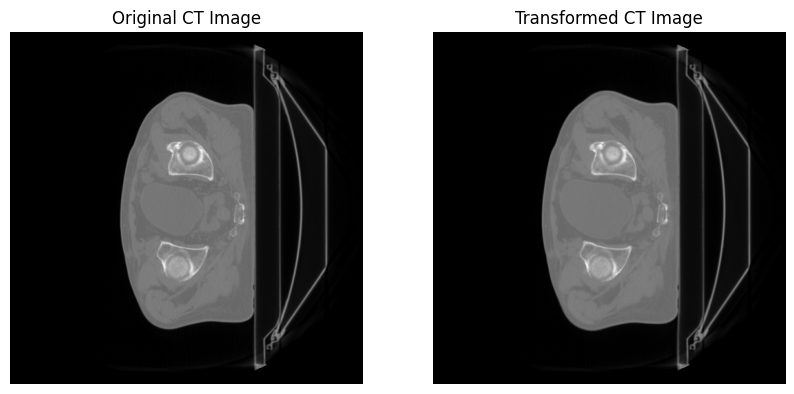

In [31]:
import matplotlib.pyplot as plt
import SimpleITK as sitk
import numpy as np

ct = sitk.ReadImage("Data/ct.nii.gz")

transformed_ct = sitk.Resample(ct, tx)

ct_array = sitk.GetArrayFromImage(ct)
transformed_ct_array = sitk.GetArrayFromImage(transformed_ct)

# Display the original and transformed images using matplotlib
plt.figure(figsize=(10, 5))

# Original CT image (Layer 1)
plt.subplot(1, 2, 1)
plt.imshow(ct_array[ct_array.shape[0] // 2, :, :], cmap="gray")
plt.title("Original CT Image")
plt.axis("off")

# Transformed CT image (Layer 2)
plt.subplot(1, 2, 2)
plt.imshow(transformed_ct_array[transformed_ct_array.shape[0] // 2, :, :], cmap="gray")
plt.title("Transformed CT Image")
plt.axis("off")

plt.show()